### **Model Training with Federated Learning**

In [1]:
# Install required packages
import pandas as pd
import numpy as np
import time
import os
import keras
import json
from flwr.client import ClientApp
import tensorflow as tf
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
import flwr as fl
from keras import layers, Sequential, optimizers, metrics
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
import flwr as fl
from flwr.common import Scalar, NDArrays, Context, Metrics
from typing import Dict, Tuple, Any, List
from functools import partial
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

# Enable TensorFlow GPU memory growth
enable_tf_gpu_growth()

In [2]:
SAVE_DIR = "saved_fl_models"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Define the data directories of different scenarios
# scenario_name: 'path/to/data'
data_dirs = {
    'covid_response': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response',
    'covid_response_weather': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather',
    'covid_response_weather_avg_neighbour': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour',
    'covid_response_weather_avg_neighbour_vaccination': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour_vaccination',
    'covid_response_weather_avg_neighbour_vaccination_testing': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour_vaccination_testing',
    'fl_vs_centralized': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/fl_vs_centralized/centralized',
    'fl_vs_single_country': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/fl_vs_single_country',
    'group_central': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_central',
    'group_eastern': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_eastern',
    'group_nordic': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_nordic',
    'group_southern': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_southern',
    'min_feature_set': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/min_feature_set',
}

In [3]:
# Define helper functions

def load_data_federated(scenario):
    """
    Load individual csv files for federated/local scenarios and save them to pandas DataFrames.
    """
    scenario_dir = data_dirs[scenario]
    country_dfs = {}
    for filename in os.listdir(scenario_dir):
        if filename.endswith('.csv'):
            country = filename.replace('.csv', '')
            filepath = os.path.join(scenario_dir, filename)
            country_dfs[country] = pd.read_csv(filepath)
    return country_dfs

def load_data_centralized(scenario):
    """
    Load the single centralized csv file.
    """
    scenario_dir = data_dirs[scenario]
    filepath = os.path.join(scenario_dir, 'centralized_training_data.csv')
    centralized_df = pd.read_csv(filepath)
    return centralized_df

# Prepare the data for neural network training
def prepare_data(df_original, is_centralized=False):
    '''
    Rescales the data for neural network training.
    '''
    country_data = df_original.copy()
    
    if is_centralized:
        country_data = country_data.drop(columns=['country'])

    country_data = country_data.set_index('date', drop=True).sort_index()
    target_column_index = country_data.columns.get_loc('confirmed')
    Num_features = country_data.shape[1]

    country_data = country_data.astype(np.float32)

    # Split the data
    train_size = int(len(country_data) * 0.8)
    val_size = int(len(country_data) * 0.1)
    train_data = country_data[:train_size]
    val_data = country_data[train_size:train_size + val_size]
    test_data = country_data[train_size + val_size:]

    # Rescale the data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    train_data_scaled = np.nan_to_num(train_data_scaled, nan=0.0)
    val_data_scaled = scaler.transform(val_data)
    val_data_scaled = np.nan_to_num(val_data_scaled, nan=0.0)
    test_data_scaled = scaler.transform(test_data)
    test_data_scaled = np.nan_to_num(test_data_scaled, nan=0.0)

    return train_data_scaled, val_data_scaled, test_data_scaled, scaler, Num_features, target_column_index

def create_sequences(data_scaled, lookback_window, forecast_horizon, target_column_index):
    '''
    Create sequences for the LSTM model
    '''
    X, y = [], []
    if len(data_scaled) <= lookback_window + forecast_horizon:
        print("Warning: Not enough data to create sequences.")
        return np.array(X), np.array(y)
    
    for i in range(len(data_scaled) - lookback_window - forecast_horizon + 1):
        X.append(data_scaled[i:i + lookback_window])
        y.append(data_scaled[i + lookback_window: i + lookback_window + forecast_horizon, target_column_index])
    return np.array(X), np.array(y)

In [4]:
# Germany as the representative country for hyperparameter tuning

# Load Germany's data for all four scenarios: withoutvaccination and test data, only test data, only vaccination data, both vaccination and test data

Germany = pd.read_csv(os.path.join(data_dirs['covid_response'], 'Germany.csv'))

data_dict = {
    'covid_response': Germany,
}

FORECAST_HORIZON = 10
LOOKBACK_WINDOW = 21

In [5]:
# Define the LSTM model function

# kernel initializer: how weights are initialized

def get_LSTM(lookback, n_features, num_layers_hp, units_list_hp, dropout_hp, lr_hp, activation_hp, 
             kernel_initializer_hp, loss_func_hp='mean_squared_error', 
             metrics_list=[metrics.MeanAbsoluteError(),metrics.RootMeanSquaredError()], 
             forecast_horizon=1):
    """
    Define the LSTM model architecture.

    Args:
        lookback (int): Number of time steps for input.
        n_features (int): Number of features in the input data.
        num_layers_hp (int): Number of LSTM layers.
        units_list_hp (list): List of integers, number of units for each LSTM layer.
        dropout_hp (float): Dropout rate after each LSTM layer.
        lr_hp (float): Learning rate for the optimizer.
        activation_hp (str): Activation function for LSTM layers.
        loss_func (str): Loss function for compiling the model.
        kernel_initializer_hp (str): Kernel initializer for LSTM layers.
        metrics_list (list): List of metrics for compiling the model.
        forecast_horizon (int): Number of time steps to forecast. Default is 1 we change it later on.
    Returns:
        A compiled Keras Sequential model.
    """
    
    model = Sequential()
    model.add(layers.Input(shape=(lookback, n_features)))

    if len(units_list_hp) != num_layers_hp:
        raise ValueError("Length of units_list_hp must match num_layers_hp.")

    for i in range(num_layers_hp):
        # Return sequences for all LSTM layers except the last one
        return_sequences = True if i < num_layers_hp - 1 else False
        model.add(layers.LSTM(
            units=units_list_hp[i],
            activation=activation_hp,
            kernel_initializer=kernel_initializer_hp,
            return_sequences=return_sequences 
        ))
        model.add(layers.Dropout(dropout_hp))

    # Assuming you are predicting one target variable for the next time step.
    model.add(layers.Dense(forecast_horizon)) 

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr_hp),
        loss=loss_func_hp,
        metrics=metrics_list
    )
    return model

In [6]:
# Tuning of the hyperparamters of the LSTM model

# Parameters to be included in the hyperparameter tuning: number of hidden layers, number of neurons in each hidden layer, dropout rate,
# learning rate, activation function.

def build_keras_tuner(hp: kt.HyperParameters, lookback, n_features) -> keras.Model:
    """
    Builds and compiles an LSTM model with hyperparameters defined by Keras Tuner.
    This function is intended to be passed to a Keras Tuner instance.
    
    Args:
        hp: Keras Tuner HyperParameters object.
        lookback (int): The lookback window size for LSTM (fixed for a tuning session).
        n_features (int): The number of features in the input data (fixed for a tuning session).
        
    Returns:
        A compiled Keras model.
    """

    # Define hyperparameter search space
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=4, step=1, default=1)

    units_l1 = hp.Int('units_l1', min_value=32, max_value=256, step=32, default=64)
    units_l2 = hp.Int('units_l2', min_value=32, max_value=256, step=32, default=64)
    units_l3 = hp.Int('units_l3', min_value=32, max_value=256, step=32, default=64)
    units_l4 = hp.Int('units_l4', min_value=32, max_value=256, step=32, default=64)

    all_possible_units = [units_l1, units_l2, units_l3, units_l4]

    # Create the list of units to be used for the current number of layers
    units_for_this_model = [all_possible_units[i] for i in range(num_hidden_layers)]


    dropout_rate_hp = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    learning_rate_hp = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)
    activation_function_hp = hp.Choice('activation_function', values=['relu', 'tanh'], default='relu')
    
    # Add kernel initializer to tuning
    kernel_initializer_choice = hp.Choice('kernel_initializer', 
                                          values=['glorot_uniform', 'he_normal', 'orthogonal'], 
                                          default='glorot_uniform')
    
    # Add loss function to tuning
    loss_function_choice = hp.Choice('loss_function', 
                                     values=['mean_squared_error', 'mean_absolute_error'], 
                                     default='mean_squared_error')
    
    # Build the model using get_LSTM
    model = get_LSTM(
        lookback=lookback,
        n_features=n_features,
        num_layers_hp=num_hidden_layers,
        units_list_hp=units_for_this_model,
        dropout_hp=dropout_rate_hp,
        lr_hp=learning_rate_hp,
        activation_hp=activation_function_hp,
        kernel_initializer_hp=kernel_initializer_choice, # Pass tuned kernel initializer
        loss_func_hp=loss_function_choice, # Pass tuned loss function
        forecast_horizon=FORECAST_HORIZON 
    )
    
    return model

In [ ]:
# Step 1.1: Hyperparameter Tuning for the Centralized Model
SCENARIO_CENTRALIZED = 'fl_vs_centralized'

print(f"--- Starting hyperparameter tuning for centralized scenario: {SCENARIO_CENTRALIZED} ---")

# Load the single, centralized dataframe
centralized_df = load_data_centralized(SCENARIO_CENTRALIZED)

# Prepare the entire dataset
train_scaled_np_cen, val_scaled_np_cen, test_scaled_np_cen, _, Num_features_cen, target_column_index_cen = prepare_data(centralized_df, is_centralized=True)

# Create sequences from the prepared data
X_train_cen, y_train_cen = create_sequences(train_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)
X_val_cen, y_val_cen = create_sequences(val_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)
X_test_cen, y_test_cen = create_sequences(test_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)

# This function is used by Keras Tuner to build a model for each trial.
def build_keras_tuner(hp: kt.HyperParameters, lookback, n_features) -> keras.Model:
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=4, step=1, default=1)
    units_l1 = hp.Int('units_l1', min_value=32, max_value=256, step=32, default=64)
    units_l2 = hp.Int('units_l2', min_value=32, max_value=256, step=32, default=64)
    units_l3 = hp.Int('units_l3', min_value=32, max_value=256, step=32, default=64)
    units_l4 = hp.Int('units_l4', min_value=32, max_value=256, step=32, default=64)
    all_possible_units = [units_l1, units_l2, units_l3, units_l4]
    units_for_this_model = [all_possible_units[i] for i in range(num_hidden_layers)]

    dropout_rate_hp = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    learning_rate_hp = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)
    activation_function_hp = hp.Choice('activation_function', values=['relu', 'tanh'], default='relu')
    kernel_initializer_choice = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'orthogonal'], default='glorot_uniform')
    loss_function_choice = hp.Choice('loss_function', values=['mean_squared_error', 'mean_absolute_error'], default='mean_squared_error')
    
    model = get_LSTM(
        lookback=lookback, n_features=n_features, num_layers_hp=num_hidden_layers,
        units_list_hp=units_for_this_model, dropout_hp=dropout_rate_hp, lr_hp=learning_rate_hp,
        activation_hp=activation_function_hp, kernel_initializer_hp=kernel_initializer_choice,
        loss_func_hp=loss_function_choice, forecast_horizon=FORECAST_HORIZON
    )
    return model

# Create a partial function for the hypermodel
hypermodel_fn = partial(build_keras_tuner, lookback=LOOKBACK_WINDOW, n_features=Num_features_cen)

tuner = kt.Hyperband(
    hypermodel_fn,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_epochs=50,
    factor=3,
    directory='tuner_results_centralized',
    project_name=f'LSTM_tuning_{SCENARIO_CENTRALIZED}'
)

early_stopping_tuning = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

tuner.search(X_train_cen, y_train_cen, epochs=50, validation_data=(X_val_cen, y_val_cen), callbacks=[early_stopping_tuning], verbose=1)

# ---- SAVING THE HYPERPARAMETERS ----
best_hps_cen = tuner.get_best_hyperparameters(num_trials=1)[0].values
hyperparams_save_path = os.path.join(SAVE_DIR, f"best_hyperparameters_{SCENARIO_CENTRALIZED}.json")
with open(hyperparams_save_path, 'w') as f:
    json.dump(best_hps_cen, f, indent=4)
print(f"Saved best hyperparameters to {hyperparams_save_path}")

In [ ]:
# Do the hyperparameter tuning for each scenario in a loop:
start_time_hps = time.time()
for scenario, country_df in data_dict.items():
    print(f"Starting hyperparameter tuning for scenario: {scenario}")

    # Prepare the data
    train_scaled_np, val_scaled_np, test_scaled_np, scaler, Num_features, target_column_index = prepare_data(country_df)
    
    if train_scaled_np is None or val_scaled_np is None or test_scaled_np is None:
        print(f"Skipping scenario {scenario} due to insufficient data.")
        continue

    # Ensure N_FEATURES is derived correctly after potential None checks
    if train_scaled_np.ndim < 2 or train_scaled_np.shape[1] == 0:
        print(f"Skipping scenario {scenario} due to invalid shape of scaled training data.")
        continue
    
    
    # Create sequences
    X_train, y_train = create_sequences(train_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    X_val, y_val = create_sequences(val_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    X_test, y_test = create_sequences(test_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"Skipping scenario {scenario} due to insufficient sequences.")
        continue

    # Create a partial function for the hypermodel
    hypermodel_fn = partial(build_keras_tuner, lookback=LOOKBACK_WINDOW, n_features=Num_features)

    tuner_project_dir = 'tuner_results' # Keras Tuner will store its detailed logs here
    # Define the hyperparameter tuner
    tuner = kt.Hyperband(
        hypermodel_fn,
        objective=kt.Objective("val_root_mean_squared_error", direction="min"),
        max_epochs=50,
        factor=3,
        directory=tuner_project_dir,
        project_name=f'LSTM_tuning_{scenario}'
    )

    # Define an early stopping callback for the tuning process
    early_stopping_tuning = keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10, 
    restore_best_weights=True
    )

    # Search for the best hyperparameters
    print(f"Starting hyperparameter search for scenario {scenario}...")
    tuner.search(X_train, y_train,
                 epochs=50,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stopping_tuning],
                 verbose=1)
    
    end_time_hps = time.time()
    training_time_hps = end_time_hps - start_time_hps
    print(training_time_hps)
    
    # Get the best model and hyperparameters
    best_models = tuner.get_best_models(num_models=1)
    if not best_models:
        print(f"No best model found for scenario {scenario}. Skipping saving.")
        continue
    best_model = best_models[0]

    best_hyperparameters_obj = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hyperparameters_dict = best_hyperparameters_obj.values

    print(f"Best hyperparameters for scenario {scenario}: {best_hyperparameters_dict}")

    # ---- SAVING THE MODEL AND HYPERPARAMETERS ----
    model_save_path = os.path.join(SAVE_DIR, f"best_model_{scenario}.keras") # Use .keras format
    best_model.save(model_save_path)
    print(f"Saved best model for {scenario} to {model_save_path}")

    hyperparams_save_path = os.path.join(SAVE_DIR, f"best_hyperparameters_{scenario}.json")
    with open(hyperparams_save_path, 'w') as f:
        json.dump(best_hyperparameters_dict, f, indent=4)
    print(f"Saved best hyperparameters for {scenario} to {hyperparams_save_path}")

    # For clarity
    print("-" * 50)

print("Hyperparameter tuning and model saving complete for all scenarios.")

We learned the best hyperparameters with Keras tuner hyperparameter optimization. Next, we are going to use those hyperparameters in our federated learning training where central server will be initializing the hyperparameters and then share those with the client nodes.

In [ ]:
# Define the FlowerClient class and client_fn for federated learning

class CovidFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: str, X_train: np.ndarray, y_train: np.ndarray, 
                 X_val: np.ndarray, y_val: np.ndarray, X_test: np.ndarray, 
                 y_test: np.ndarray, hps: Dict[str, Any], n_features: int, 
                 lookback: int, forecast_horizon: int):
        
        self.cid = cid
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.hps = hps
        self.n_features = n_features
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.model = None
    
    def _build_model(self):

        # Construct units_list_hp from hps
        num_hidden_layers = self.hps['num_hidden_layers']

        final_units_list = [self.hps[f"units_l{i+1}"] for i in range(num_hidden_layers)]

        self.model = get_LSTM(
            lookback=self.lookback,
            n_features=self.n_features,
            num_layers_hp=self.hps["num_hidden_layers"],
            units_list_hp=final_units_list,
            dropout_hp=self.hps["dropout_rate"],
            lr_hp=self.hps["learning_rate"],  # Initial learning rate for compilation
            activation_hp=self.hps["activation_function"],
            kernel_initializer_hp=self.hps["kernel_initializer"],
            loss_func_hp=self.hps["loss_function"],
            forecast_horizon=self.forecast_horizon
        )
    
    def get_parameters(self, config: Dict[str, Scalar]) -> NDArrays:
        if self.model is None:
            self._build_model()
        return self.model.get_weights()
    
    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        if self.model is None:
            self._build_model()

        self.model.set_weights(parameters)

        # Client-side early stopping
        early_stopping_cb = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Assuming 'val_loss' is available if X_val, y_val used
            patience=5,          # Number of epochs with no improvement after which training will be stopped.
            restore_best_weights=True
        )
        
        # Check if validation data is available
        validation_data = None
        if self.X_val is not None and len(self.X_val) > 0 and \
           self.y_val is not None and len(self.y_val) > 0:
            validation_data = (self.X_val, self.y_val)

        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=int(config["local_epochs"]),
            batch_size=int(config["batch_size"]),
            validation_data=validation_data,
            callbacks=[early_stopping_cb] if validation_data else [],
            verbose=1  # Suppress detailed Keras output for cleaner FL logs
        )
        
        # Extract metrics from the last epoch
        results = {
            "loss": history.history["loss"][-1],
        }
        if validation_data:
            results["val_loss"] = history.history["val_loss"][-1]
            results["val_rmse"] = history.history["val_root_mean_squared_error"][-1]
            results["val_mae"] = history.history["val_mean_absolute_error"][-1]


        return self.model.get_weights(), len(self.X_train), results
    
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        if self.model is None:
            self._build_model()

        self.model.set_weights(parameters)

        # Ensure test data is available
        if self.X_test is None or len(self.X_test) == 0 or \
           self.y_test is None or len(self.y_test) == 0:
            # Return zero loss, zero samples, and empty metrics if no test data
            return 0.0, 0, {}

        loss, rmse, mae = self.model.evaluate(
            self.X_test, self.y_test,
            batch_size=int(config.get("batch_size", 32)), # Use batch_size from config or default
            verbose=1
        )
        return float(loss), len(self.X_test), {"rmse": float(rmse), "mae": float(mae)}

In [ ]:
def get_client_fn(Data_dict, hps: Dict[str, Any], n_features: int, lookback: int, forecast_horizon: int):

    country_keys_list: List[str] = sorted(list(Data_dict.keys()))

    def client_fn(context: Context):

        partition_id: int = context.node_config["partition-id"]

        if partition_id >= len(country_keys_list):
            raise IndexError(
                f"partition_id {partition_id} is out of bounds for country_keys_list "
                f"(length {len(country_keys_list)}). "
                f"Ensure num_supernodes in run_simulation does not exceed the "
                f"number of unique data partitions (countries: {len(country_keys_list)})."
            )
        
        country_name_for_client: str = country_keys_list[partition_id]

        print(f"[Client Factory] Client with partition_id {partition_id} assigned to data for country: {country_name_for_client}") # For debugging
        

        X_train, y_train, X_val, y_val, X_test, y_test = Data_dict[country_name_for_client]

        return CovidFlowerClient(cid = country_name_for_client, X_train=X_train, y_train = y_train, X_val = X_val, y_val=y_val, X_test=X_test, 
                                 y_test=y_test, lookback=lookback, n_features=n_features, hps=hps,forecast_horizon=forecast_horizon).to_client()
    
    return client_fn



In [ ]:
# Custom aggregation function for fit metrics
def fit_metrics_aggregation_fn(all_client_metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregate metrics from the fit stage using weighted average."""
    aggregated_fit_metrics = {}
    # Metrics returned by CovidFlowerClient.fit in the 'results' dictionary
    metric_keys_to_aggregate = ["loss", "val_loss", "val_rmse", "val_mae"] 
    
    for key in metric_keys_to_aggregate:
        # Collect metrics for the current key from all clients that reported it
        key_specific_metrics = []
        for num_examples, metrics_dict in all_client_metrics:
            if metrics_dict and key in metrics_dict: # Check if metrics_dict is not None
                key_specific_metrics.append((num_examples, metrics_dict[key]))
        
        if key_specific_metrics:
            # Calculate weighted average for this specific metric
            total_examples_for_key = sum(ex for ex, _ in key_specific_metrics)
            if total_examples_for_key > 0:
                weighted_sum = sum(ex * val for ex, val in key_specific_metrics)
                # Prefix with 'fit_' to distinguish in logs/history
                aggregated_fit_metrics[f"fit_{key}"] = weighted_sum / total_examples_for_key
            elif key_specific_metrics: # All num_examples are 0, but values exist
                # Calculate simple average if values exist
                simple_avg = sum(val for _, val in key_specific_metrics) / len(key_specific_metrics)
                aggregated_fit_metrics[f"fit_{key}"] = simple_avg
                
    return aggregated_fit_metrics


# Custom aggregation function for evaluate metrics
def evaluate_metrics_aggregation_fn(all_client_metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregate metrics from the evaluate stage using weighted average."""
    aggregated_eval_metrics = {}
    # Metrics returned by CovidFlowerClient.evaluate in the metrics dictionary
    metric_keys_to_aggregate = ["rmse", "mae"] 
    
    for key in metric_keys_to_aggregate:
        key_specific_metrics = []
        for num_examples, metrics_dict in all_client_metrics:
            # Ensure metrics_dict is not None and key exists
            if metrics_dict and key in metrics_dict:
                key_specific_metrics.append((num_examples, metrics_dict[key]))
        
        if key_specific_metrics:
            total_examples_for_key = sum(ex for ex, _ in key_specific_metrics)
            if total_examples_for_key > 0:
                weighted_sum = sum(ex * val for ex, val in key_specific_metrics)
                # Prefix with 'eval_' to distinguish in logs/history
                aggregated_eval_metrics[f"eval_{key}"] = weighted_sum / total_examples_for_key
            elif key_specific_metrics: # All num_examples are 0, but values exist
                simple_avg = sum(val for _, val in key_specific_metrics) / len(key_specific_metrics)
                aggregated_eval_metrics[f"eval_{key}"] = simple_avg
                
    return aggregated_eval_metrics

In [ ]:
def get_server_fn(num_rounds: int, num_total_clients: int,
                  initial_learning_rate: float, local_epochs: int, batch_size: int,
                  ):

    def fit_config_fn(server_round: int) -> Dict[str, Scalar]:
        """Return training configuration dict for each round."""
        # Here you can implement more complex logic, e.g., learning rate scheduling
        config = {
            "learning_rate": initial_learning_rate,
            "local_epochs": local_epochs,
            "batch_size": batch_size,
        }
        return config

    def evaluate_config_fn(server_round: int) -> Dict[str, Scalar]:
        """Return evaluation configuration dict for each round."""
        # Pass batch_size for evaluation, or other eval-specific params
        config = {
            "batch_size": batch_size,
        }
        return config
    
    def server_fn(context: Context):

        strategy = FedAvg(
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_fit_clients=num_total_clients,
            min_evaluate_clients=num_total_clients,
            min_available_clients=num_total_clients,
            on_fit_config_fn=fit_config_fn,       # Pass the config function for fit
            on_evaluate_config_fn=evaluate_config_fn, # Pass the config function for evaluate
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

        config = ServerConfig(num_rounds=num_rounds)

        return ServerAppComponents(strategy=strategy, config=config)
    
    return server_fn

In [ ]:
start_time_fl = time.time()

SCENARIO = 'covid_response'

# backend_config = {"client_resources": {"num_cpus": 4.0, "num_gpus": 1.0}}

FL_NUM_ROUNDS = 50
FL_LOCAL_EPOCHS = 1
FL_BATCH_SIZE = 32

# Main FL Training

# Prepare the data
country_dfs = load_data(SCENARIO) # A dict
num_actual_clients = len(country_dfs)

node_dict = {}
hps_dict = {}

hps_directory = r"D:\Masterarbeit\Code\Final Simulations\saved_fl_models"

for filename in os.listdir(hps_directory):
    if filename.endswith(".json") and filename.startswith("best_hyperparameters_"):
        # Extract the key from the filename
        file_key = filename.replace("best_hyperparameters_", "").replace(".json", "")
        # Or in Python 3.9+: file_key = filename.removeprefix("best_hyperparameters_").removesuffix(".json")

        filepath = os.path.join(hps_directory, filename)
        with open(filepath, "r") as f:
            try:
                hyperparams = json.load(f)
                hps_dict[file_key] = hyperparams
            except json.JSONDecodeError as e:
                print(f"Error decoding {filename}: {e}")
        break

if SCENARIO not in hps_dict:
    raise ValueError(f"Hyperparameters for scenario '{SCENARIO}' not found in {hps_directory}")

hps = hps_dict[SCENARIO]
fl_initial_lr = hps["learning_rate"]

server_fn = get_server_fn(
    num_rounds=FL_NUM_ROUNDS,
    num_total_clients=num_actual_clients, # Use actual number of clients
    initial_learning_rate=fl_initial_lr,
    local_epochs=FL_LOCAL_EPOCHS,
    batch_size=FL_BATCH_SIZE,
)
server = ServerApp(server_fn=server_fn)

for country_name, df in country_dfs.items():

    train_scaled_np, val_scaled_np, test_scaled_np, scaler_, Num_features, target_column_index = prepare_data(df)

    x_train, y_train = create_sequences(train_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    x_val, y_val = create_sequences(val_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    x_test, y_test = create_sequences(test_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)

    

    if len(x_train) == 0:
        print(f"Warning: Client {country_name} has no training sequences. Skipping this client for FL.")
        num_actual_clients -= 1 # Adjust if you are dynamically setting num_total_clients
        continue # Skip adding to node_dict
    
    # Store everything in a dictionary keyed by country name
    node_dict[country_name] = (x_train, y_train, x_val, y_val, x_test, y_test)


_, _, _, _, Num_features, _ = prepare_data(country_dfs['Germany'])


client_fn = get_client_fn(Data_dict=node_dict, hps=hps, n_features=Num_features,
                           lookback=LOOKBACK_WINDOW, forecast_horizon=FORECAST_HORIZON)

client = ClientApp(client_fn=client_fn)

history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=num_actual_clients,
)


end_time_fl = time.time()
training_time_fl = end_time_fl - start_time_fl
print(f"Total FL training time: {training_time_fl} seconds") # Modified to see the value


In [ ]:
hps_directory = r"D:\Masterarbeit\Code\Final Simulations\FL_vs_Centralized\saved_fl_models"
best_hps_cen = {}
for filename in os.listdir(hps_directory):
    if filename.endswith(".json") and filename.startswith("best_hyperparameters_"):
        # Extract the key from the filename
        file_key = filename.replace("best_hyperparameters_", "").replace(".json", "")
        # Or in Python 3.9+: file_key = filename.removeprefix("best_hyperparameters_").removesuffix(".json")

        filepath = os.path.join(hps_directory, filename)
        with open(filepath, "r") as f:
            try:
                hyperparams = json.load(f)
                best_hps_cen[file_key] = hyperparams
            except json.JSONDecodeError as e:
                print(f"Error decoding {filename}: {e}")
        break

In [ ]:
best_hps_cen

In [ ]:
# Step 1.2: Train and Evaluate the Final Centralized Model
print("\n--- Training Final Centralized Model ---")

num_hidden_layers = best_hps_cen['num_hidden_layers']
units_list = [best_hps_cen[f"units_l{i+1}"] for i in range(num_hidden_layers)]

centralized_model = get_LSTM(
    lookback=LOOKBACK_WINDOW,
    n_features=Num_features_cen,
    num_layers_hp=num_hidden_layers,
    units_list_hp=units_list,
    dropout_hp=best_hps_cen["dropout_rate"],
    lr_hp=best_hps_cen["learning_rate"],
    activation_hp=best_hps_cen["activation_function"],
    kernel_initializer_hp=best_hps_cen["kernel_initializer"],
    loss_func_hp=best_hps_cen["loss_function"],
    forecast_horizon=FORECAST_HORIZON
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# We use the full training and validation data to train the final model
X_train_full = np.concatenate((X_train_cen, X_val_cen), axis=0)
y_train_full = np.concatenate((y_train_cen, y_val_cen), axis=0)

history_centralized = centralized_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(X_test_cen, y_test_cen), # Use test set for final validation monitoring
    verbose=1
)

# Evaluate the final model on the test set
loss_cen, centralized_rmse, centralized_mae = centralized_model.evaluate(X_test_cen, y_test_cen, verbose=0)
print(f"\nEvaluation for Centralized Model: RMSE={centralized_rmse:.4f}, MAE={centralized_mae:.4f}")

In [8]:
# Step 1.1: Define hyperparameters and prepare data
SCENARIO_CENTRALIZED = 'fl_vs_centralized'

best_hps_cen = {
    'num_hidden_layers': 1,
    'units_l1': 224,
    'units_l2': 64, # This will be ignored since num_hidden_layers is 1
    'units_l3': 224, # This will be ignored
    'units_l4': 256, # This will be ignored
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'activation_function': 'relu',
    'kernel_initializer': 'he_normal',
    'loss_function': 'mean_absolute_error'
}

print(f"--- Training Centralized Model for scenario: {SCENARIO_CENTRALIZED} ---")

# Load and prepare the centralized dataset
centralized_df = load_data_centralized(SCENARIO_CENTRALIZED)
train_scaled_np_cen, val_scaled_np_cen, test_scaled_np_cen, _, Num_features_cen, target_column_index_cen = prepare_data(centralized_df, is_centralized=True)

# Create sequences
X_train_cen, y_train_cen = create_sequences(train_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)
X_val_cen, y_val_cen = create_sequences(val_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)
X_test_cen, y_test_cen = create_sequences(test_scaled_np_cen, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index_cen)

# Step 1.2: Build, Train, and Evaluate the Centralized Model
num_hidden_layers = best_hps_cen['num_hidden_layers']
units_list = [best_hps_cen[f"units_l{i+1}"] for i in range(num_hidden_layers)]

centralized_model = get_LSTM(
    lookback=LOOKBACK_WINDOW,
    n_features=Num_features_cen,
    num_layers_hp=num_hidden_layers,
    units_list_hp=units_list,
    dropout_hp=best_hps_cen["dropout_rate"],
    lr_hp=best_hps_cen["learning_rate"],
    activation_hp=best_hps_cen["activation_function"],
    kernel_initializer_hp=best_hps_cen["kernel_initializer"],
    loss_func_hp=best_hps_cen["loss_function"],
    forecast_horizon=FORECAST_HORIZON
)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_centralized = centralized_model.fit(
    X_train_cen, y_train_cen,
    epochs=50,
    validation_data=(X_val_cen, y_val_cen),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the final model on the test set
loss_cen, centralized_rmse, centralized_mae = centralized_model.evaluate(X_test_cen, y_test_cen, verbose=0)
print(f"\nEvaluation for Centralized Model: RMSE={centralized_rmse:.4f}, MAE={centralized_mae:.4f}")

--- Training Centralized Model for scenario: fl_vs_centralized ---
Epoch 1/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.4186 - mean_absolute_error: 0.4186 - root_mean_squared_error: 1.0742 - val_loss: 0.2644 - val_mean_absolute_error: 0.2644 - val_root_mean_squared_error: 0.9649
Epoch 2/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2647 - mean_absolute_error: 0.2647 - root_mean_squared_error: 0.9882 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_root_mean_squared_error: 0.9501
Epoch 3/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2670 - mean_absolute_error: 0.2670 - root_mean_squared_error: 1.0109 - val_loss: 0.2603 - val_mean_absolute_error: 0.2603 - val_root_mean_squared_error: 0.9507
Epoch 4/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2646 - mean_absolute_error: 0.2646 - root_mean_squared_error: 1.0010 - val_loss: 0.2583 - val_mean_absolute_error: 0.2583 - val_root_mean_squared_error: 0.9574
Epoch 5/50
832/832 ━━━━━━━━━━━━━━━━━━

In [ ]:
# This code would go in a new cell after your simulation finishes
print("Federated Learning Training Complete.")

# The history object contains metrics from each round. Let's look at the last round.
final_round = FL_NUM_ROUNDS - 1
final_metrics = history.metrics_distributed

print("\n--- Final Federated Model Aggregated Performance ---")
# The keys will be like 'eval_rmse', 'eval_mae' as defined in your aggregation function
# The value is a list of (round_number, metric_value) tuples.
if 'eval_rmse' in final_metrics:
    final_rmse = final_metrics['eval_rmse'][-1][1] # Get the metric from the last round
    print(f"Average RMSE across all clients: {final_rmse:.4f}")

if 'eval_mae' in final_metrics:
    final_mae = final_metrics['eval_mae'][-1][1]
    print(f"Average MAE across all clients: {final_mae:.4f}")

In [9]:
# This code would go in a new cell.
# We'll use the same hyperparameters from the centralized model for a fair comparison.

print("\n--- Starting Training of Individual Local Models ---\n")

# Use the pre-defined hyperparameters
best_hps = best_hps_cen 

# This will store the results: {'Germany': {'rmse': x, 'mae': y}, ...}
local_model_results = {}

# Get the full dictionary of country dataframes
SCENARIO_LOCAL = 'covid_response'
all_country_dfs = load_data_federated(SCENARIO_LOCAL) 

for country_name, df in all_country_dfs.items():
    print(f"Training local model for: {country_name}")

    # 1. Prepare data for this specific country
    train_scaled, val_scaled, test_scaled, _, n_features, target_idx = prepare_data(df)
    
    if train_scaled is None or len(train_scaled) < (LOOKBACK_WINDOW + FORECAST_HORIZON):
        print(f"Skipping {country_name} due to insufficient data.")
        continue

    X_train, y_train = create_sequences(train_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)
    X_val, y_val = create_sequences(val_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)
    X_test, y_test = create_sequences(test_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"Skipping {country_name} due to insufficient sequences.")
        continue
    
    # 2. Build the model using the pre-defined best hyperparameters
    num_hidden_layers = best_hps['num_hidden_layers']
    units_list = [best_hps[f"units_l{i+1}"] for i in range(num_hidden_layers)]
    
    local_model = get_LSTM(
        lookback=LOOKBACK_WINDOW,
        n_features=n_features,
        num_layers_hp=num_hidden_layers,
        units_list_hp=units_list,
        dropout_hp=best_hps["dropout_rate"],
        lr_hp=best_hps["learning_rate"],
        activation_hp=best_hps["activation_function"],
        kernel_initializer_hp=best_hps["kernel_initializer"],
        loss_func_hp=best_hps["loss_function"],
        forecast_horizon=FORECAST_HORIZON
    )

    # 3. Train the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    local_model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # 4. Evaluate the model on its own test set
    loss, rmse, mae = local_model.evaluate(X_test, y_test, verbose=0)
    print(f"Evaluation for {country_name}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    # 5. Store the results
    local_model_results[country_name] = {'rmse': rmse, 'mae': mae}

print("\n--- Local Model Training Complete ---")


--- Starting Training of Individual Local Models ---

Training local model for: Austria
Evaluation for Austria: RMSE=0.3088, MAE=0.5726
Training local model for: Belgium
Evaluation for Belgium: RMSE=0.3659, MAE=0.7478
Training local model for: Bulgaria
Evaluation for Bulgaria: RMSE=0.3347, MAE=0.5353
Training local model for: Croatia
Evaluation for Croatia: RMSE=0.2785, MAE=0.4621
Training local model for: Cyprus
Evaluation for Cyprus: RMSE=0.5011, MAE=1.1246
Training local model for: Czechia
Evaluation for Czechia: RMSE=0.3870, MAE=0.7013
Training local model for: Denmark
Evaluation for Denmark: RMSE=0.1480, MAE=0.3789
Training local model for: Estonia
Evaluation for Estonia: RMSE=0.2265, MAE=0.4228
Training local model for: Finland
Evaluation for Finland: RMSE=0.4556, MAE=0.8781
Training local model for: France
Evaluation for France: RMSE=0.3996, MAE=0.8285
Training local model for: Germany
Evaluation for Germany: RMSE=0.4150, MAE=0.8360
Training local model for: Greece
Evaluation f

\n========================================
--- FINAL MODEL PERFORMANCE COMPARISON ---
Approach                  |   RMSE   |   MAE
----------------------------------------
Centralized Model           | 0.2595   | 0.9474
Average of Local Models     | 0.3187   | 0.6535
Federated Global Model (FL) | 0.4459   | 0.7241


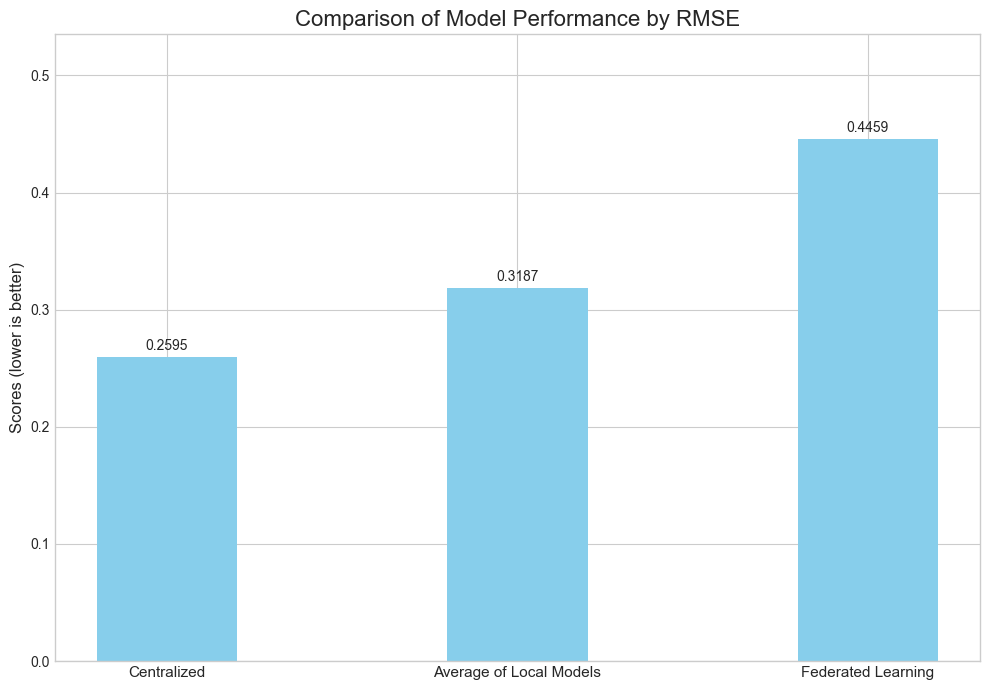

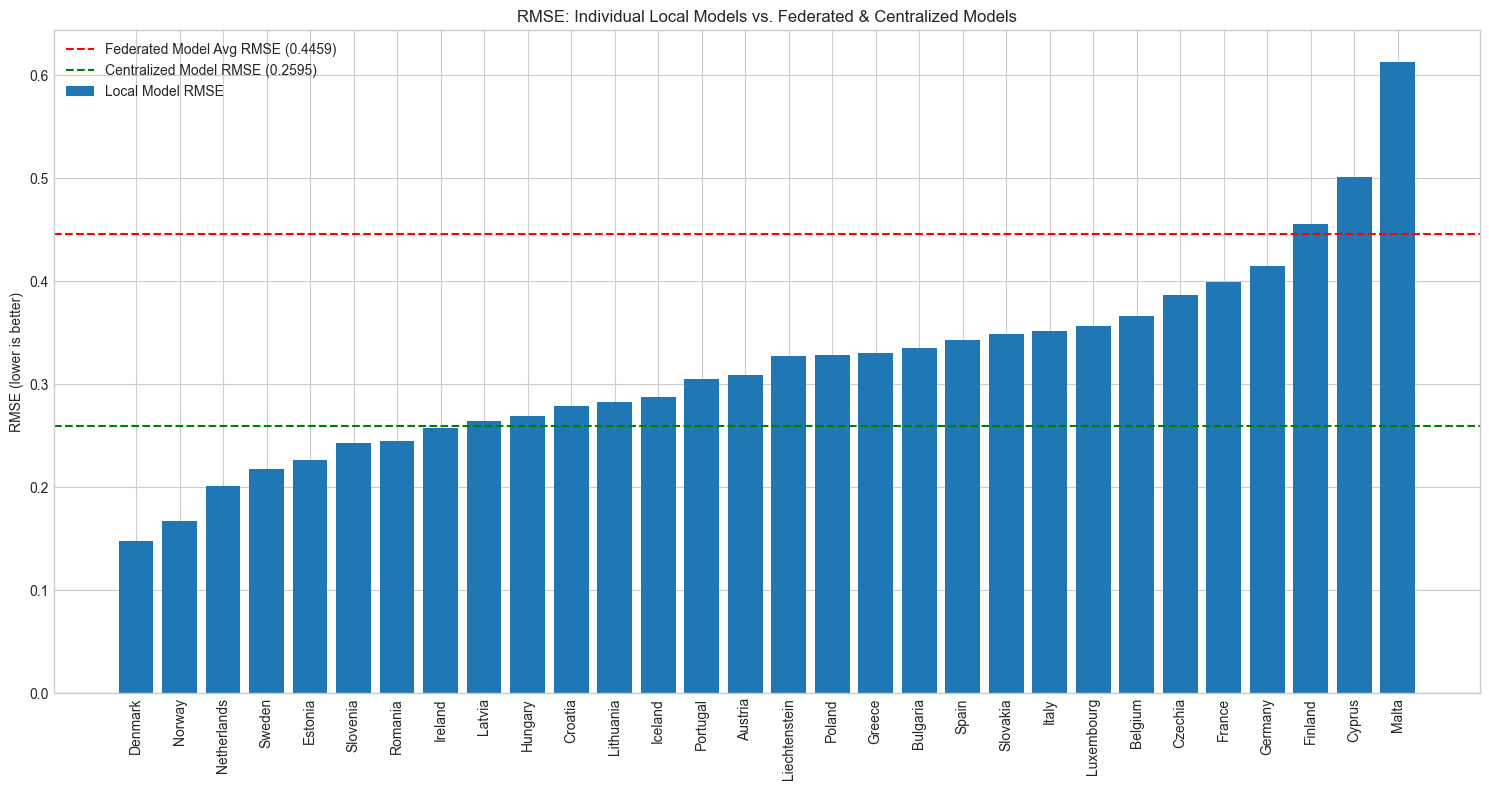

In [14]:
# --- Step 1: Collect all results ---

# Average Local Model Performance
local_results_df = pd.DataFrame.from_dict(local_model_results, orient='index')
avg_local_rmse = local_results_df['rmse'].mean()
avg_local_mae = local_results_df['mae'].mean()

# Centralized Model Performance (from cell where it was trained)
# This uses the variables `centralized_rmse` and `centralized_mae`

# Federated Global Model Performance (from your simulation log output)
# We manually copy the final aggregated metrics from the simulation log.
federated_rmse = 0.4459
federated_mae = 0.7241

# --- Step 2: Print the summary table ---
print("\\n" + "="*40)
print("--- FINAL MODEL PERFORMANCE COMPARISON ---")
print("="*40)
print(f"Approach                  |   RMSE   |   MAE")
print("-"*40)
print(f"Centralized Model           | {centralized_rmse:.4f}   | {centralized_mae:.4f}")
print(f"Average of Local Models     | {avg_local_rmse:.4f}   | {avg_local_mae:.4f}")
print(f"Federated Global Model (FL) | {federated_rmse:.4f}   | {federated_mae:.4f}")
print("="*40)

# --- Step 3: Visualize the RMSE results ---
labels = ['Centralized', 'Average of Local Models', 'Federated Learning']
rmse_values = [centralized_rmse, avg_local_rmse, federated_rmse]

x = np.arange(len(labels))
width = 0.4  # You can make the bars a bit wider now

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('seaborn-v0_8-whitegrid')

# RMSE Bar Plot
rects = ax.bar(x, rmse_values, width, label='RMSE', color='skyblue')

# Add labels, title, and ticks
ax.set_ylabel('Scores (lower is better)', fontsize=12)
ax.set_title('Comparison of Model Performance by RMSE', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.bar_label(rects, padding=3, fmt='%.4f')
ax.set_ylim(0, max(rmse_values) * 1.2) # Set y-limit to give some space above the bars

fig.tight_layout()
plt.show()

# --- Optional: Detailed Local vs. Baselines Plot ---
plt.figure(figsize=(15, 8))
local_results_df_sorted = local_results_df.sort_values('rmse')
plt.bar(local_results_df_sorted.index, local_results_df_sorted['rmse'], label='Local Model RMSE')
plt.axhline(y=federated_rmse, color='r', linestyle='--', label=f'Federated Model Avg RMSE ({federated_rmse:.4f})')
plt.axhline(y=centralized_rmse, color='g', linestyle='--', label=f'Centralized Model RMSE ({centralized_rmse:.4f})')
plt.xticks(rotation=90)
plt.title('RMSE: Individual Local Models vs. Federated & Centralized Models')
plt.ylabel('RMSE (lower is better)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# This code would go in a new cell.

# Create a pandas DataFrame for easy comparison
local_results_df = pd.DataFrame.from_dict(local_model_results, orient='index')
local_results_df = local_results_df.reset_index().rename(columns={'index': 'Country', 'rmse': 'Local_RMSE', 'mae': 'Local_MAE'})

# Calculate the average performance of local models
avg_local_rmse = local_results_df['Local_RMSE'].mean()
avg_local_mae = local_results_df['Local_MAE'].mean()

# Get the federated results from Step 1
avg_federated_rmse =  0.445
avg_federated_mae = 0.724

print("\n--- FINAL COMPARISON ---")
print(f"Average Local Model RMSE: {avg_local_rmse:.4f}")
print(f"Federated Global Model RMSE: {avg_federated_rmse:.4f}")
print("-" * 20)
print(f"Average Local Model MAE: {avg_local_mae:.4f}")
print(f"Federated Global Model MAE: {avg_federated_mae:.4f}")


# Visualize the results
plt.figure(figsize=(15, 8))
local_results_df.sort_values('Local_RMSE', inplace=True)
plt.bar(local_results_df['Country'], local_results_df['Local_RMSE'], label='Local Model RMSE')
plt.axhline(y=avg_federated_rmse, color='r', linestyle='--', label=f'Federated Model Avg RMSE ({avg_federated_rmse:.4f})')
plt.xticks(rotation=90)
plt.title('Comparison of Local Model RMSE vs. Federated Model Average RMSE')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Manually define the results data from your logs ---

# Data for the Federated Global Model (copied directly from your log output)
# The round number is simply 1 to 50.
rounds = list(range(1, 51))

federated_rmse_history = [
    0.5798578558291978, 0.5701600514373532, 0.5640525904284497, 0.5501060211934806, 0.5445181471683863,
    0.5350097793299476, 0.528032082302292, 0.5221956394440084, 0.5135796826852439, 0.5073153049953588,
    0.5040503173109088, 0.5007792027586114, 0.49567335881610963, 0.49366129295474004, 0.49103812808523145,
    0.48792836177925986, 0.48711280278094954, 0.48628994289235694, 0.4854825932521944, 0.4842136276112479,
    0.48166023941968894, 0.48302035233071783, 0.48123848429779154, 0.4814468290491674, 0.47998758736011604,
    0.4793429620482176, 0.47905769631502926, 0.47710696474814523, 0.4759377430807822, 0.4733689236490646,
    0.4725035374583438, 0.4692451223918896, 0.47031465001879985, 0.4689937854695485, 0.46735646992303725,
    0.4630284213884035, 0.46395393653389105, 0.46238844388139205, 0.462970901657867, 0.4619149036187377,
    0.45782252617753005, 0.4573832475688216, 0.45686438101585825, 0.4534278627138111, 0.4531242704430263,
    0.4509547893935076, 0.44922017373656686, 0.449828456903968, 0.449438872413453, 0.445907962169527
]

federated_mae_history = [
    0.9337155866448401, 0.9124378695774971, 0.8958574149753079, 0.8805185079623064, 0.8669536604101749,
    0.8537868018701048, 0.8414582114677305, 0.8318007777938518, 0.8223437478068205, 0.8151066402634647,
    0.8094312074272649, 0.8043862753352676, 0.7979402047630828, 0.795409275608947, 0.792333279333739,
    0.7870445570939922, 0.7867957480121502, 0.7838882227261991, 0.783176250043755, 0.7793281218442262,
    0.7762705551845943, 0.7744411747840518, 0.7766690604228128, 0.7732918714303804, 0.7733527583627984,
    0.7725303227119011, 0.7713549742615285, 0.7670341789504288, 0.7668289037776604, 0.7625135544016381,
    0.7582543934928347, 0.7562930357800407, 0.7550467255397656, 0.7536595310802234, 0.7503626299806124,
    0.7452098598393933, 0.7464523692109711, 0.7466956052221676, 0.7453418933748956, 0.7459993010955692,
    0.7396258567226957, 0.7391576103293445, 0.7395921403821671, 0.7348332607610384, 0.732371701426795,
    0.7295742517275847, 0.7265756449693584, 0.7286078507893451, 0.7282151584704749, 0.7241588263019113
]


# Data for the Average of Local Models (from your calculation)
avg_local_rmse = 0.36
avg_local_mae = 0.6658


# --- Step 2: Create the RMSE Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the federated model's RMSE at each round
ax.plot(rounds, federated_rmse_history, marker='o', linestyle='-', label='Federated Global Model RMSE', markersize=5)

# Plot the average local model performance as a horizontal line for comparison
ax.axhline(y=avg_local_rmse, color='r', linestyle='--', linewidth=2, 
           label=f'Average Local Model RMSE')

ax.set_title('Federated Model Learning Curve vs. Local Model Benchmark (RMSE)', fontsize=16)
ax.set_xlabel('Federated Learning Round', fontsize=12)
ax.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure x-axis ticks are integers for clarity
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


# --- Step 3: Create the MAE Plot ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the federated model's MAE at each round
ax.plot(rounds, federated_mae_history, marker='o', linestyle='-', label='Federated Global Model MAE', color='green', markersize=5)
    
# Plot the average local model performance as a horizontal line
ax.axhline(y=avg_local_mae, color='r', linestyle='--', linewidth=2, 
           label=f'Average Local Model MAE ({avg_local_mae:.4f})')

ax.set_title('Federated Model Learning Curve vs. Local Model Benchmark (MAE)', fontsize=16)
ax.set_xlabel('Federated Learning Round', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure x-axis ticks are integers for clarity
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()